In [29]:
# submission best = 0.65078
import numpy as np
from numpy import log1p
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.neural_network import MLPRegressor

# load each dataset
holidayEventsData = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oilData = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
storesData = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
transactionsData = pd.read_csv('store-sales-time-series-forecasting/transactions.csv')
testData = pd.read_csv('store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
trainData = pd.read_csv('store-sales-time-series-forecasting/train.csv', parse_dates=['date'])

In [3]:
# change to datetime
trainData['date'] = pd.to_datetime(trainData['date'])
testData['date'] = pd.to_datetime(testData['date'])
oilData['date'] = pd.to_datetime(oilData['date'])
holidayEventsData['date'] = pd.to_datetime(holidayEventsData['date'])
transactionsData['date'] = pd.to_datetime(transactionsData['date'])

In [4]:
# fix similar column names
storesData.rename(columns={'type': 'store_type'}, inplace=True)
holidayEventsData.rename(columns={'type': 'holiday_type'}, inplace=True)

# fill missing
oilData['dcoilwtico'].fillna(method='bfill', inplace=True)

# remove 0 sales
trainData = trainData[trainData['sales'] > 0]

# normalize sales
trainData['sales'] = np.log1p(trainData['sales'])

/var/folders/t8/kft3r9x14dv07wt1prr3tmc00000gn/T/ipykernel_73808/3702773968.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oilData['dcoilwtico'].fillna(method='bfill', inplace=True)
/var/folders/t8/kft3r9x14dv07wt1prr3tmc00000gn/T/ipykernel_73808/3702773968.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oilData['dcoilwtico'].fillna(method='bfill', inplace=True)


In [5]:
# merging data
train = trainData.merge(storesData, on='store_nbr', how='left')
train = train.merge(oilData, on='date', how='left')
train = train.merge(holidayEventsData, on='date', how='left')
train.fillna(0, inplace=True)
testData = testData.merge(storesData, on='store_nbr', how='left')
testData = testData.merge(oilData, on='date', how='left')
testData = testData.merge(holidayEventsData, on='date', how='left')
testData.fillna(0, inplace=True)

In [6]:
# convert all categorical to numerical
for col in ['family', 'city', 'state', 'store_type', 'holiday_type', 'locale', 'description', 'locale_name', 'transferred']:
    if col in train.columns:
        train[col] = train[col].astype('category').cat.codes
        testData[col] = testData[col].astype('category').cat.codes

In [7]:
clf = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', alpha=1e-5, max_iter=1000, learning_rate = 'adaptive',random_state=1)

In [8]:
# feature selection
xTrain = train.drop(['date', 'id', 'sales'], axis=1)
xTest = testData.drop(['date', 'id'], axis=1)
yTrain = train['sales']
selector = SelectKBest(f_regression, k=10)
xTrain = selector.fit_transform(xTrain, yTrain)
xTest = selector.transform(xTest)

In [9]:
# scale data
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [10]:
# fit model
clf.fit(xTrain, yTrain)
yPred = np.expm1(clf.predict(xTest))

In [36]:
# inverse transform the train data
trainInv = train[['date', 'sales']].copy()
trainInv['sales'] = np.expm1(trainInv['sales'])

# setup test prediction data
testPred = testData[['date']].copy()
testPred['sales'] = yPred

# aggregate sales by date
trainAgg = trainInv.groupby('date').sum().reset_index()
testAgg = testPred.groupby('date').sum().reset_index()

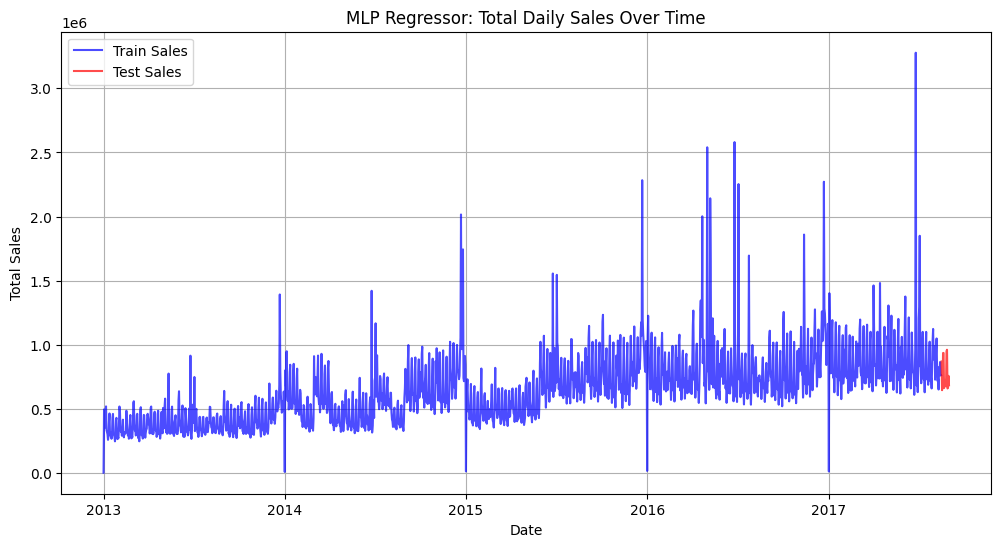

In [37]:
# plot the results; regression line and scatter plot of predictions and actual values from train
plt.figure(figsize=(12, 6))
plt.plot(trainAgg['date'], trainAgg['sales'], color='blue', label='Train Sales', alpha=0.7)
plt.plot(testAgg['date'], testAgg['sales'], color='red', label='Test Sales', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('MLP Regressor: Total Daily Sales Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# export to csv in format (id, sales)
testData['sales'] = yPred
testData[['id', 'sales']].to_csv('submission.csv', index=False)